In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the Excel file
mines_location = pd.read_excel('/content/drive/MyDrive/Research files/Lithium mines with coordinates via geocode.xlsx')
mines_location

,Location,Country,Full Address,Latitude,Longitude
0,Tanco,Canada,Tanco Canada,56.130366,-106.346771
1,Separation Rapids,Canada,Separation Rapids Canada,56.130366,-106.346771
2,James Bay,Canada,James Bay Canada,53.536891,-80.545652
3,Rose,Canada,Rose Canada,56.130366,-106.346771
4,Whabouchi,Canada,Whabouchi Canada,51.688958,-75.836340
...,...,...,...,...,...
83,Mount Marion,Australia,Mount Marion Australia,-27.186667,119.521667
84,Bald Hill,Australia,Bald Hill Australia,-34.221342,150.993903
85,Buldania,Australia,Buldania Australia,-34.727657,116.249796
86,Narraburra,Australia,Narraburra Australia,-34.312232,147.642805


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Research files/sorted_df.csv')
df.head(10)

,city,lat,lng,country,admin_name,similarity
0,manado,1.4931,124.8413,Indonesia,Sulawesi Utara,0.355365
1,laramie,41.3099,-105.6085,United States,Wyoming,0.311937
2,cincinnati,39.1413,-84.5060,United States,Ohio,0.291255
3,pasco,46.2506,-119.1305,United States,Washington,0.281586
4,sherwood,45.3594,-122.8427,United States,Oregon,0.273497
5,sherwood,34.8507,-92.2029,United States,Arkansas,0.273497
6,wyoming,39.2297,-84.4816,United States,Ohio,0.267059
7,wyoming,42.8908,-85.7066,United States,Michigan,0.267059
8,alliance,40.9107,-81.1189,United States,Ohio,0.266676
9,formosa,-26.1833,-58.1833,Argentina,Formosa,0.265784


In [ ]:
coor_true = {
    'Location': mines_location['Location'],
    'Latitude': mines_location['Latitude'],
    'Longitude': mines_location['Longitude']
}
coor_true_df = pd.DataFrame(coor_true)

In [ ]:
coor_true_df

,Location,Latitude,Longitude
0,Tanco,56.130366,-106.346771
1,Separation Rapids,56.130366,-106.346771
2,James Bay,53.536891,-80.545652
3,Rose,56.130366,-106.346771
4,Whabouchi,51.688958,-75.836340
...,...,...,...
83,Mount Marion,-27.186667,119.521667
84,Bald Hill,-34.221342,150.993903
85,Buldania,-34.727657,116.249796
86,Narraburra,-34.312232,147.642805


In [ ]:
from sklearn.neighbors import NearestNeighbors

def combined_cities_and_mines(df) :
  coor_est = {
      'City': df['city'],
      'Latitude': df['lat'],
      'Longitude': df['lng']
  }
  coor_est_df_full = pd.DataFrame(coor_est)
  coor_est_df = coor_est_df_full.head(10)

  # Convert lat/lon to numpy arrays
  cities_coords = coor_est_df[['Latitude', 'Longitude']].to_numpy()
  mines_coords = coor_true_df[['Latitude', 'Longitude']].to_numpy()

  # Use Nearest Neighbors to find the closest mine for each city
  nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(mines_coords)
  distances, indices = nbrs.kneighbors(cities_coords)

  # Extract matched mine coordinates
  matched_mines_coords = mines_coords[indices.flatten()]

  # Add matched mine information to the cities dataframe
  output_df = coor_est_df
  output_df['closest_mine'] = coor_true_df.iloc[indices.flatten()]['Location'].values
  output_df['lat_mine'] = matched_mines_coords[:, 0]
  output_df['lon_mine'] = matched_mines_coords[:, 1]
  return output_df

In [ ]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of earth in kilometers
    return c * r

In [ ]:
# Calculate the distance error
output_df = combined_cities_and_mines(df)

output_df['error_km'] = output_df.apply(lambda row: haversine(row['Latitude'], row['Longitude'],
                                                              row['lat_mine'], row['lon_mine']), axis=1)

print(output_df)

         City  Latitude  Longitude     closest_mine   lat_mine    lon_mine  \
0      manado    1.4931   124.8413      Pilgangoora -21.048363  118.897232   
1     laramie   41.3099  -105.6085        McDermitt  41.997297 -117.718997   
2  cincinnati   39.1413   -84.5060   Kings Mountain  35.245134  -81.341194   
3       pasco   46.2506  -119.1305        McDermitt  41.997297 -117.718997   
4    sherwood   45.3594  -122.8427     Kings Valley  44.706786 -123.434548   
5    sherwood   34.8507   -92.2029         Magnolia  30.209379  -95.750782   
6     wyoming   39.2297   -84.4816   Kings Mountain  35.245134  -81.341194   
7     wyoming   42.8908   -85.7066   Kings Mountain  35.245134  -81.341194   
8    alliance   40.9107   -81.1189   Kings Mountain  35.245134  -81.341194   
9     formosa  -26.1833   -58.1833  Salar de Olaroz -24.263254  -65.216093   

      error_km  
0  2588.587877  
1  1008.219376  
2   515.933972  
3   486.156990  
4    86.191252  
5   613.870084  
6   522.973718  
7   9

<ipython-input-6-8e4eb703aa9a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['closest_mine'] = coor_true_df.iloc[indices.flatten()]['Location'].values
<ipython-input-6-8e4eb703aa9a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['lat_mine'] = matched_mines_coords[:, 0]
<ipython-input-6-8e4eb703aa9a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [ ]:
# Calculate RMSE
rmse = np.sqrt(np.mean(output_df['error_km']**2))
print(f"RMSE of geolocation errors: {rmse:.4f} km")

RMSE of geolocation errors: 1033.6767 km


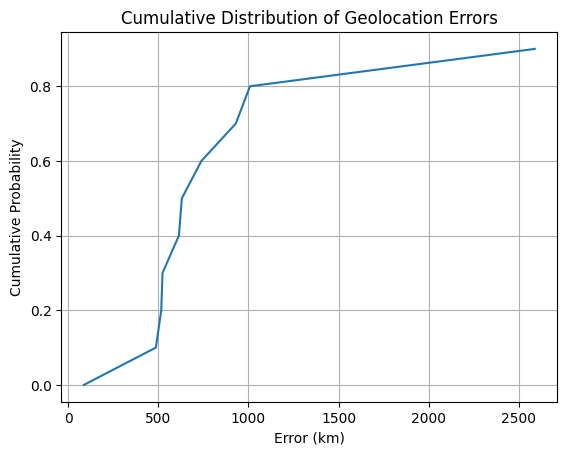

In [ ]:
import matplotlib.pyplot as plt

# CDF of errors
sorted_errors = np.sort(output_df['error_km'])
cdf = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.plot(sorted_errors, cdf)
plt.title('Cumulative Distribution of Geolocation Errors')
plt.xlabel('Error (km)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

**Start Experimenting on the following dimensional reduction technique**
- PCA
- AE
- VAE
- VAE with LSTM

In [ ]:
cities = pd.read_csv("/content/drive/MyDrive/Research files/worldcities.csv")
cities_df = pd.DataFrame(cities)

# Convert the 'city' column to lowercase
cities_df['city'] = cities_df['city'].str.lower()

In [ ]:
from scipy.spatial.distance import cosine



# Define cosine similarity function
def compute_cosine_similarity(vector1, vector2):
    return 1 - cosine(vector1, vector2)

def calculate_similarities(df, target_word):
    # # Load your data
    # df = mydf_filtered

    # # Select target word
    # target_word = "lithium"

    # Compute similarities
    target_vector = df[df.iloc[:, 0] == target_word].iloc[:, 1:].values.flatten()
    similarities = []
    for index, row in df.iterrows():
        word = row.iloc[0]
        word_vector = row.iloc[1:].values
        similarity = compute_cosine_similarity(target_vector, word_vector)
        similarities.append((word, similarity))

    # Convert to DataFrame for easier comparison
    similarities_df = pd.DataFrame(similarities, columns=['city', 'similarity'])

    return similarities_df

In [ ]:
mydf_filtered = pd.read_csv('/content/drive/MyDrive/Research files/mydf_filtered.csv')

# Example usage
target_word = "lithium"
similarities_df = calculate_similarities(mydf_filtered, target_word)
print(similarities_df.head())

     city  similarity
0    gold   -0.009144
1   mines   -0.185748
2   creek   -0.222610
3    work   -0.085197
4  copper   -0.046915


In [ ]:
dictionary = cities_df[['city', 'lat', 'lng', 'country', 'admin_name']]


In [ ]:
common_words = pd.Series(list(set(dictionary['city']).intersection(set(similarities_df['city']))))

print(common_words.shape)
# There is a word called nan that got identified as not word, so it got filtered

(1130,)


In [ ]:
similarities_df.sort_values('similarity', ascending=False)

,city,similarity
5987,lithium,1.000000
10516,metaborate,0.718989
4210,fusion,0.538660
3518,inductively,0.533122
3922,spectrometry,0.434614
...,...,...
1870,considerably,-0.304792
102,access,-0.304835
1114,shore,-0.329455
416,good,-0.368623


In [ ]:
def merge_and_sort_df(similarities_df, dictionary):
    # Unzip the word_similarity_pairs to get a list of words and similarity scores
    word_list = list(similarities_df['city'])
    similarity_list = list(similarities_df['similarity'])

    # Create a new dataframe from the word_similarity_pairs
    sim_df = pd.DataFrame({
        'city': word_list,
        'similarity': similarity_list
    })

    # Filter the original dataframe to extract rows that match the words in word_list
    filtered_df = dictionary[dictionary['city'].isin(word_list)]

    # Merge the filtered dataframe with the similarity dataframe on the 'word' column
    merged_df = pd.merge(filtered_df, sim_df, on='city', how='left')

    # Sort the merged dataframe based on the similarity column in descending order
    sorted_df = merged_df.sort_values(by='similarity', ascending=False)

    return sorted_df

In [ ]:
# Sort the merged dataframe based on the similarity column in descending order
sorted_df = merge_and_sort_df(similarities_df, dictionary)


print(sorted_df)

            city      lat       lng        country        admin_name  \
101       manado   1.4931  124.8413      Indonesia    Sulawesi Utara   
823      laramie  41.3099 -105.6085  United States           Wyoming   
35    cincinnati  39.1413  -84.5060  United States              Ohio   
561        pasco  46.2506 -119.1305  United States        Washington   
1102    sherwood  45.3594 -122.8427  United States            Oregon   
...          ...      ...       ...            ...               ...   
65      victoria  48.4283 -123.3647         Canada  British Columbia   
1655    victoria  44.8634  -93.6585  United States         Minnesota   
1319    robinson  40.4578  -80.1334  United States      Pennsylvania   
1488    robinson  31.4501  -97.1201  United States             Texas   
570       mackay -21.1411  149.1858      Australia        Queensland   

      similarity  
101     0.355365  
823     0.311937  
35      0.291255  
561     0.281586  
1102    0.273497  
...          ...  
65

**Let's take the table from all 4 techniques**

- start with PCA

In [ ]:
pca_df = pd.read_csv('/content/drive/MyDrive/Research files/PCA_reduced_data.csv')
pca_df.head()

,Word,PC1,PC2
0,gold,-4.933172,1.120176
1,mines,-4.412772,3.158488
2,creek,-4.767795,1.718639
3,work,-4.985589,1.005441
4,copper,-4.697652,1.020338


In [ ]:
target_word = "lithium"
pca_similarities_df = calculate_similarities(pca_df, target_word)
print(pca_similarities_df.head())

     city  similarity
0    gold   -0.971503
1   mines   -0.987444
2   creek   -0.993208
3    work   -0.965461
4  copper   -0.969231


In [ ]:
pca_sorted_df = merge_and_sort_df(pca_similarities_df, dictionary)
pca_sorted_df.head()

,city,lat,lng,country,admin_name,similarity
1191,tiffin,41.1165,-83.1805,United States,Ohio,0.999966
1446,beaufort,32.4597,-80.7235,United States,South Carolina,0.999929
1604,vashon,47.4122,-122.4726,United States,Washington,0.999927
208,metro,-5.1167,105.3000,Indonesia,Lampung,0.999836
485,pierre,44.3748,-100.3205,United States,South Dakota,0.999775


In [ ]:
# Calculate the distance error
pca_err_distance_df = combined_cities_and_mines(pca_sorted_df)

pca_err_distance_df['error_km'] = pca_err_distance_df.apply(lambda row: haversine(row['Latitude'], row['Longitude'],
                                                              row['lat_mine'], row['lon_mine']), axis=1)
pca_err_distance_df.head()

<ipython-input-6-8e4eb703aa9a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['closest_mine'] = coor_true_df.iloc[indices.flatten()]['Location'].values
<ipython-input-6-8e4eb703aa9a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['lat_mine'] = matched_mines_coords[:, 0]
<ipython-input-6-8e4eb703aa9a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

,City,Latitude,Longitude,closest_mine,lat_mine,lon_mine,error_km
1191,tiffin,41.1165,-83.1805,Kings Mountain,35.245134,-81.341194,672.320367
1446,beaufort,32.4597,-80.7235,Kings Mountain,35.245134,-81.341194,314.932404
1604,vashon,47.4122,-122.4726,Kings Valley,44.706786,-123.434548,309.842539
208,metro,-5.1167,105.3000,Wodgina,-21.183463,118.665993,2295.598426
485,pierre,44.3748,-100.3205,Separation Rapids,56.130366,-106.346771,1374.298146


In [ ]:
# Calculate RMSE
rmse = np.sqrt(np.mean(pca_err_distance_df['error_km']**2))
print(f"RMSE of geolocation errors: {rmse:.4f} km")

RMSE of geolocation errors: 1662.5537 km


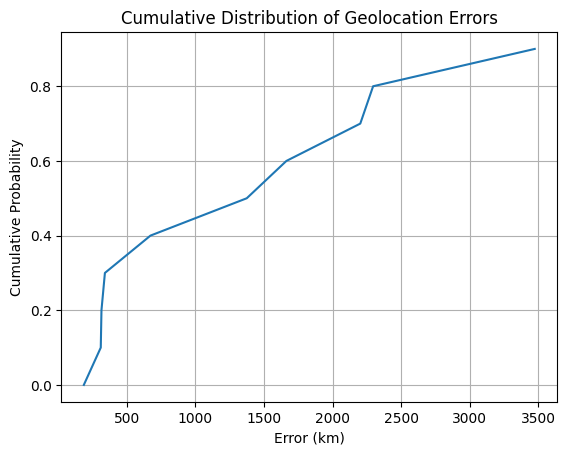

In [ ]:
# CDF of errors
sorted_errors = np.sort(pca_err_distance_df['error_km'])
cdf = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.plot(sorted_errors, cdf)
plt.title('Cumulative Distribution of Geolocation Errors')
plt.xlabel('Error (km)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

**PCA is done!**
-
-
- Next is autoencoder

In [ ]:
ae_df = pd.read_csv('/content/drive/MyDrive/Research files/AE_reduced_data.csv')
ae_df.head()

,Word,dim1,dim2
0,gold,0.276072,3.095828
1,mines,1.725683,4.812866
2,creek,0.200911,8.479065
3,work,0.103334,2.704090
4,copper,0.331058,3.994173


In [ ]:
target_word = "lithium"
ae_similarities_df = calculate_similarities(ae_df, target_word)
print(ae_similarities_df.head())

     city  similarity
0    gold    0.540379
1   mines    0.735377
2   creek    0.484365
3    work    0.497003
4  copper    0.535114


In [ ]:
ae_sorted_df = merge_and_sort_df(ae_similarities_df, dictionary)
ae_sorted_df.head(10)

,city,lat,lng,country,admin_name,similarity
107,laval,45.5833,-73.7500,Canada,Quebec,1.000000
663,laval,48.0733,-0.7689,France,Pays de la Loire,1.000000
906,alvin,29.3872,-95.2938,United States,Texas,1.000000
516,trim,53.5550,-6.7917,Ireland,Meath,1.000000
1795,moe,-38.1722,146.2678,Australia,Victoria,1.000000
772,sion,46.2333,7.3667,Switzerland,Valais,0.999998
493,puck,54.7000,18.4000,Poland,Pomorskie,0.999997
1757,evergreen,39.6349,-105.3356,United States,Colorado,0.999996
431,northwood,51.6010,-0.4176,United Kingdom,Hillingdon,0.999996
347,bellevue,48.8710,2.3850,France,Île-de-France,0.999995


In [ ]:
# Calculate the distance error
ae_err_distance_df = combined_cities_and_mines(ae_sorted_df)

ae_err_distance_df['error_km'] = ae_err_distance_df.apply(lambda row: haversine(row['Latitude'], row['Longitude'],
                                                              row['lat_mine'], row['lon_mine']), axis=1)
ae_err_distance_df.head()

<ipython-input-6-8e4eb703aa9a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['closest_mine'] = coor_true_df.iloc[indices.flatten()]['Location'].values
<ipython-input-6-8e4eb703aa9a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['lat_mine'] = matched_mines_coords[:, 0]
<ipython-input-6-8e4eb703aa9a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

,City,Latitude,Longitude,closest_mine,lat_mine,lon_mine,error_km
107,laval,45.5833,-73.7500,Val-d’Or,48.098711,-77.796768,415.793112
663,laval,48.0733,-0.7689,Chédeville,45.974290,1.391674,285.099889
906,alvin,29.3872,-95.2938,Magnolia,30.209379,-95.750782,101.500497
516,trim,53.5550,-6.7917,Aclare,54.036462,-8.896653,148.247781
1795,moe,-38.1722,146.2678,Narraburra,-34.312232,147.642805,446.554487


In [ ]:
# Calculate RMSE
rmse = np.sqrt(np.mean(ae_err_distance_df['error_km']**2))
print(f"RMSE of geolocation errors: {rmse:.4f} km")

RMSE of geolocation errors: 511.8307 km


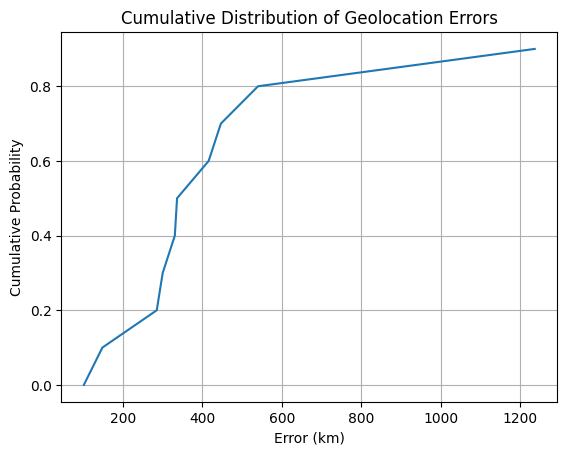

In [ ]:
# CDF of errors
sorted_errors = np.sort(ae_err_distance_df['error_km'])
cdf = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.plot(sorted_errors, cdf)
plt.title('Cumulative Distribution of Geolocation Errors')
plt.xlabel('Error (km)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

**Autoencoder is done!**
-
-
- Next is VAE

In [ ]:
vae_df = pd.read_csv('/content/drive/MyDrive/Research files/VAE_reduced_data.csv')
vae_df.head()

,Word,Dim1,Dim2
0,gold,29.317108,-4.620698
1,mines,-7.578801,7.181572
2,creek,6.279577,57.479565
3,work,28.323800,-2.563523
4,copper,27.627247,-3.591809


In [ ]:
target_word = "lithium"
vae_similarities_df = calculate_similarities(vae_df, target_word)
print(vae_similarities_df.head())

     city  similarity
0    gold    0.072116
1   mines    0.505524
2   creek    0.992846
3    work    0.137802
4  copper    0.099057


In [ ]:
vae_sorted_df = merge_and_sort_df(vae_similarities_df, dictionary)
vae_sorted_df.head(10)

,city,lat,lng,country,admin_name,similarity
1539,center,40.6483,-80.2977,United States,Pennsylvania,0.999999
299,tota,6.8000,1.7833,Benin,Couffo,0.999999
1004,westerly,41.3635,-71.7899,United States,Rhode Island,0.999996
856,eagle,43.7223,-116.3866,United States,Idaho,0.999993
18,phoenix,33.5722,-112.0892,United States,Arizona,0.999993
981,kalispell,48.2153,-114.3274,United States,Montana,0.999984
618,pontiac,42.6493,-83.2878,United States,Michigan,0.999982
1528,pontiac,40.8894,-88.6409,United States,Illinois,0.999982
1170,albino,45.7606,9.7969,Italy,Lombardy,0.999977
1220,barrington,41.7443,-71.3145,United States,Rhode Island,0.999977


In [ ]:
# Calculate the distance error
vae_err_distance_df = combined_cities_and_mines(vae_sorted_df)

vae_err_distance_df['error_km'] = vae_err_distance_df.apply(lambda row: haversine(row['Latitude'], row['Longitude'],
                                                              row['lat_mine'], row['lon_mine']), axis=1)
vae_err_distance_df.head()

<ipython-input-6-8e4eb703aa9a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['closest_mine'] = coor_true_df.iloc[indices.flatten()]['Location'].values
<ipython-input-6-8e4eb703aa9a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['lat_mine'] = matched_mines_coords[:, 0]
<ipython-input-6-8e4eb703aa9a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

,City,Latitude,Longitude,closest_mine,lat_mine,lon_mine,error_km
1539,center,40.6483,-80.2977,Kings Mountain,35.245134,-81.341194,607.717761
299,tota,6.8000,1.7833,Ewoyaa,5.238474,-1.062173,359.376725
1004,westerly,41.3635,-71.7899,Val-d’Or,48.098711,-77.796768,885.956233
856,eagle,43.7223,-116.3866,McDermitt,41.997297,-117.718997,220.414342
18,phoenix,33.5722,-112.0892,Salton Sea,33.328618,-115.843412,349.336414


In [ ]:
# Calculate RMSE
rmse = np.sqrt(np.mean(vae_err_distance_df['error_km']**2))
print(f"RMSE of geolocation errors: {rmse:.4f} km")

RMSE of geolocation errors: 654.9757 km


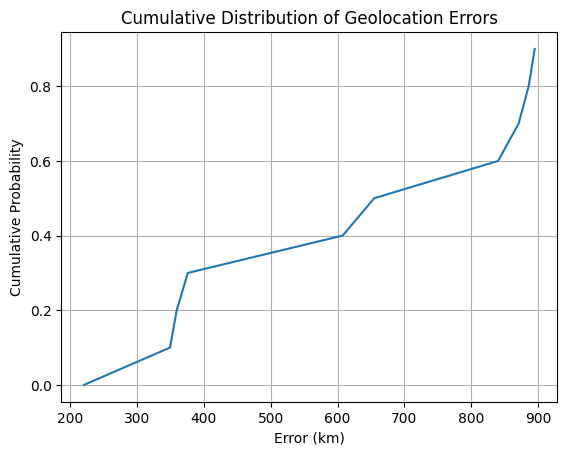

In [ ]:
# CDF of errors
sorted_errors = np.sort(vae_err_distance_df['error_km'])
cdf = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.plot(sorted_errors, cdf)
plt.title('Cumulative Distribution of Geolocation Errors')
plt.xlabel('Error (km)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

**VAE is done!**
-
-
- Next is VAE_LSTM

In [ ]:
vae_lstm_df = pd.read_csv('/content/drive/MyDrive/Research files/VAE_LSTM_reduced_data.csv')
vae_lstm_df.head()

,Word,LatentDim_1,LatentDim_2
0,gold,-0.712100,0.053557
1,mines,0.249579,-1.114365
2,creek,1.750212,-0.644575
3,work,2.163980,1.457885
4,copper,2.575934,-2.049365


In [ ]:
target_word = "lithium"
vae_lstm_similarities_df = calculate_similarities(vae_lstm_df, target_word)
print(vae_lstm_similarities_df.head())

     city  similarity
0    gold   -0.727975
1   mines    0.867836
2   creek    0.888086
3    work    0.146902
4  copper    0.987471


In [ ]:
vae_lstm_sorted_df = merge_and_sort_df(vae_lstm_similarities_df, dictionary)
vae_lstm_sorted_df.head(10)

,city,lat,lng,country,admin_name,similarity
1562,apt,43.8761,5.3964,France,Provence-Alpes-Côte d’Azur,1.000000
1053,evans,40.3660,-104.7390,United States,Colorado,1.000000
751,evans,33.5619,-82.1351,United States,Georgia,1.000000
1306,evans,42.6528,-79.0063,United States,New York,1.000000
572,moa,20.6397,-74.9175,Cuba,Holguín,1.000000
873,takahashi,34.7914,133.6164,Japan,Okayama,1.000000
955,sand,59.1343,10.2244,Norway,Vestfold og Telemark,0.999999
1784,fitzgerald,31.7134,-83.2514,United States,Georgia,0.999999
1684,tut,37.7967,37.9150,Turkey,Adıyaman,0.999999
421,clifton,52.9040,-1.1770,United Kingdom,Nottingham,0.999999


In [ ]:
# Calculate the distance error
vae_lstm_err_distance_df = combined_cities_and_mines(vae_lstm_sorted_df)

vae_lstm_err_distance_df['error_km'] = vae_lstm_err_distance_df.apply(lambda row: haversine(row['Latitude'], row['Longitude'],
                                                              row['lat_mine'], row['lon_mine']), axis=1)
vae_lstm_err_distance_df.head()

<ipython-input-6-8e4eb703aa9a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['closest_mine'] = coor_true_df.iloc[indices.flatten()]['Location'].values
<ipython-input-6-8e4eb703aa9a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['lat_mine'] = matched_mines_coords[:, 0]
<ipython-input-6-8e4eb703aa9a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

,City,Latitude,Longitude,closest_mine,lat_mine,lon_mine,error_km
1562,apt,43.8761,5.3964,Chédeville,45.974290,1.391674,392.142158
1053,evans,40.3660,-104.7390,Sonora,29.297225,-110.330881,1331.646604
751,evans,33.5619,-82.1351,Kings Mountain,35.245134,-81.341194,200.837602
1306,evans,42.6528,-79.0063,Val-d’Or,48.098711,-77.796768,612.860603
572,moa,20.6397,-74.9175,Kings Mountain,35.245134,-81.341194,1741.158339


In [ ]:
# Calculate RMSE
rmse = np.sqrt(np.mean(vae_lstm_err_distance_df['error_km']**2))
print(f"RMSE of geolocation errors: {rmse:.4f} km")

RMSE of geolocation errors: 1094.7798 km


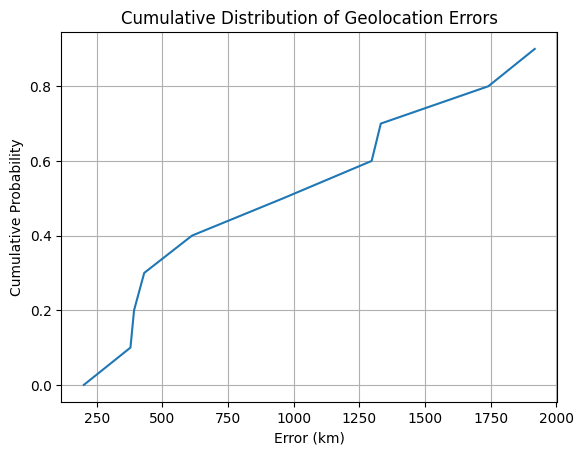

In [ ]:
# CDF of errors
sorted_errors = np.sort(vae_lstm_err_distance_df['error_km'])
cdf = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.plot(sorted_errors, cdf)
plt.title('Cumulative Distribution of Geolocation Errors')
plt.xlabel('Error (km)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()